In [1]:
%matplotlib inline
import os
from os.path import join
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import gc
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as T
import pytorch_lightning as pl  
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.functional import accuracy
from torchsummaryX import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns 
from torchviz import make_dot
import warnings
warnings.filterwarnings("ignore")

BATCH_SIZE = 64
seed_everything(42)
USE_CUDA = torch.cuda.is_available() 
AVAIL_GPUS = min(1, torch.cuda.device_count())
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print(USE_CUDA)
print('pytorch version :',torch.__version__)
print('Training device :',device)
print('cuda index :', torch.cuda.current_device())
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Global seed set to 42


True
pytorch version : 1.9.1
Training device : cuda:0
cuda index : 0


# EDA / Preprocessing

In [2]:
def removebrackets(array):
    if array.shape == (1, 1):
        return "".join(array[0])
    elif array.shape == (0, 0):
        return None

df = pd.read_pickle(r"C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\Week1\LSWMD.pkl")
df.rename(columns = {'trianTestLabel':'TrainTestLabel'}, inplace = 'True')
df['TrainTestLabel'] = df['TrainTestLabel'].apply(removebrackets)
df['failureType'] = df['failureType'].apply(removebrackets)
df = df.dropna()

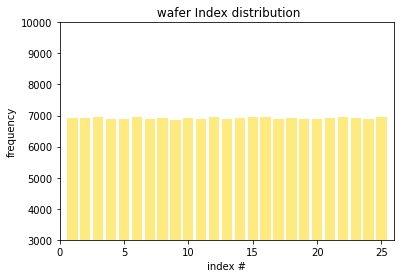

In [3]:
%matplotlib inline
uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(3000, 10000)
plt.show()
# 매우 균일한 분포를 보이므로, waferindex는 고려하지 않아도 됨.

In [4]:
df = df.drop(['waferIndex'], axis = 1)

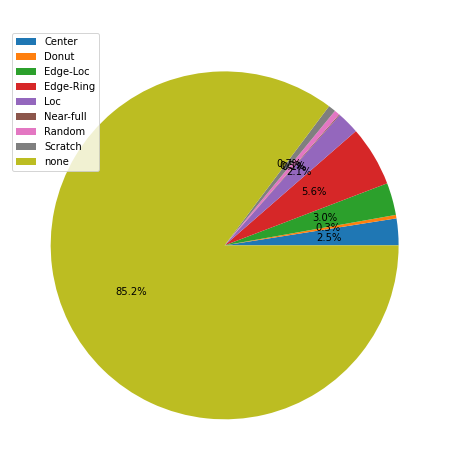

In [5]:
# failureType
label = df.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

# Loc, Edge-loc에 비해 Near-full, Donut들의 인스턴스 개수가 매우 작음.

In [6]:
faulty_case = np.unique(label)
print('Faulty case list : {}'.format(faulty_case))

faulty_case_dict = {}
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(label[label==f]))) # label[label==f] : y에서 label==f인 행들만 뽑는다
    faulty_case_dict[i] = f

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']
Center : 4294
Donut : 555
Edge-Loc : 5189
Edge-Ring : 9680
Loc : 3593
Near-full : 149
Random : 866
Scratch : 1193
none : 147431


In [7]:
# None 클래스 드랍
NONE = df.loc[(df.failureType == 'none'),:].sample(10000)
df.drop(df[df.failureType == 'none'].index, inplace = True)
print(NONE.shape)
print(df.shape)

(10000, 5)
(25519, 5)


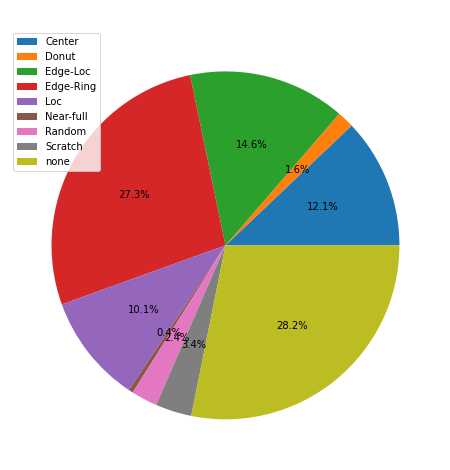

In [8]:
df = pd.concat([df, NONE], ignore_index=True)

# 원래 failureType 분포
label = df.failureType.values
plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [9]:
encoder = LabelEncoder()
y = encoder.fit_transform(label)

faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

faulty_case_dict = {}
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f]))) # y[y==f] : y에서 y==f인 행들만 뽑는다
    faulty_case_dict[i] = f

Faulty case list : [0 1 2 3 4 5 6 7 8]
0 : 4294
1 : 555
2 : 5189
3 : 9680
4 : 3593
5 : 149
6 : 866
7 : 1193
8 : 10000


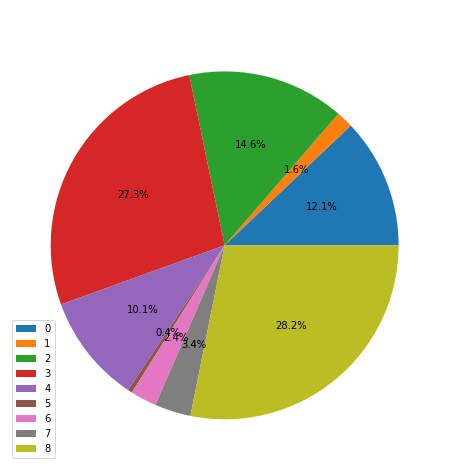

In [10]:
# None 드랍 후의 failureType 분포

plt.figure(figsize=(8, 8))
labels = np.unique(y, return_counts=True)[0]
counts = np.unique(y, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

## Resize

In [11]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
    
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)
# waferMapDim 열 생성 
#df.groupby("waferMapDim").size().sort_values(ascending=False)[:20]

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim
17380,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot40551,Test,Edge-Loc,"(26, 26)"
3923,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3036.0,lot9335,Training,Edge-Ring,"(63, 62)"
23378,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1376.0,lot45790,Test,Scratch,"(44, 41)"
12050,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2126.0,lot21579,Training,Edge-Ring,"(53, 52)"
18384,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",845.0,lot42205,Test,Edge-Loc,"(35, 31)"


In [12]:
size = 64
def resize(arr):
    img = Image.fromarray(arr)
    img = img.resize((size, size), Image.BICUBIC)
    return np.asarray(img)
# 킹재우
def vis(x, y, label):
    fig = plt.figure(figsize=(8, 24))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.matshow(x)
    ax1.axis("off")
    ax1.set_title("Original of " + str(label))
    ax2.matshow(y)
    ax2.axis("off")
    ax2.set_title("Cubic of " + str(label))
    plt.show()

In [13]:
df['resized_wafer']=df.waferMap.apply(resize)

In [14]:
df.head()

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim,resized_wafer
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,Loc,"(45, 48)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


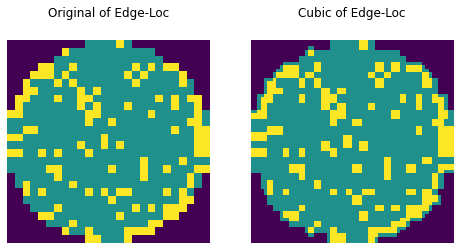

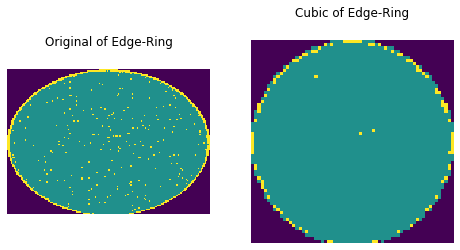

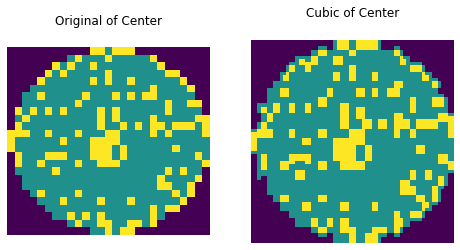

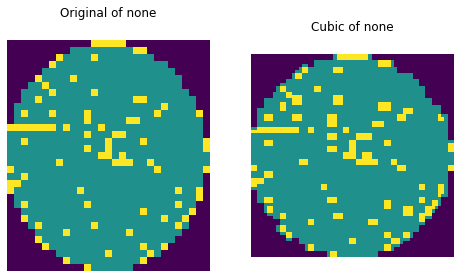

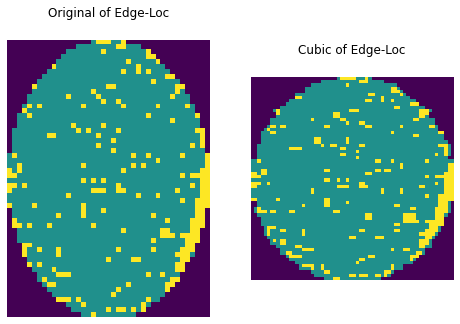

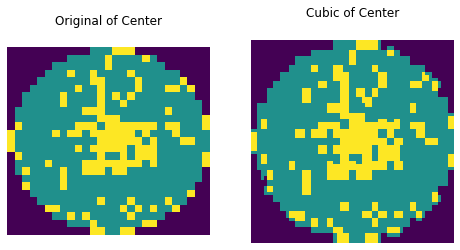

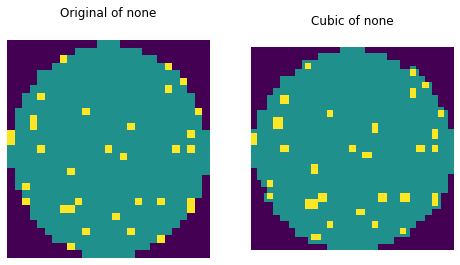

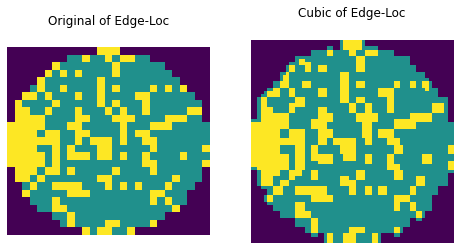

In [15]:
number_of_sample = 8
sample = df.sample(number_of_sample)
WAFER = sample.waferMap.values
CUBIC = sample.resized_wafer.values
LB = sample.failureType.values
for i in range(number_of_sample):
  vis(WAFER[i], CUBIC[i], LB[i])

# Dataset

In [16]:
images = df.resized_wafer.values
X = np.empty((len(images), size, size))
for i in range(len(images)):
      X[i,:,:] = images[i]

X_OHE = torch.empty((len(X), 3, size, size))
for i in range(len(X)):
    tmp = F.one_hot(torch.as_tensor(X[i, :, :]).to(torch.int64), 3)
    tmp = tmp.permute(2, 0, 1)
    X_OHE[i] = tmp
del X, tmp, df
X_OHE = X_OHE.type(torch.float)
y = torch.as_tensor(y, dtype=torch.long)
print(X_OHE.shape, y.shape)

torch.Size([35519, 3, 64, 64]) torch.Size([35519])


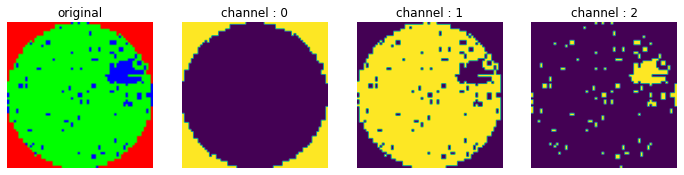

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(4*3, 1*3))

idx = 0
ax = axes[0]
ax.imshow(X_OHE[idx].permute(1,2,0))
ax.set_title("original")
ax.axis('off')

for i in range(3):
  ax = axes[i + 1]
  ax.imshow(X_OHE[idx, i, :, :])
  ax.set_title("channel : {}".format(i))
  ax.axis('off')
plt.show()
# 0(없음)이 보라색 1(있음)이 노란색
# 채널 0은 배경, 채널 1은 정상, 채널 2는 비정상 
# 0, 1, 2 - R, G, B

In [18]:
# Transforms and Dataset
class WaferDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        label = self.y[idx]
        return x, label

transform = T.RandomApply([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    #T.RandomRotation(degrees=(-180, 180)),
    #T.RandomResizedCrop(size=(64, 64), scale=(0.6, 1.0), interpolation = T.InterpolationMode.BILINEAR)
], p=0.5)

# dataset for vae
X_train, X_val, y_train, y_val = train_test_split(X_OHE, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

train_dataset = WaferDataset(X_train, y_train, transform=transform)
val_dataset = WaferDataset(X_val, y_val, transform=None)
test_dataset = WaferDataset(X_test, y_test, transform=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(len(X_train), len(X_val), len(X_test))
print(next(iter(train_loader))[0].shape)

24863 5328 5328
torch.Size([64, 3, 64, 64])


# Variational Autoencoder for augmentation

In [19]:
class ConvVAE(nn.Module):
    def __init__(self, c_in=3, latent_dim=1024):
        super().__init__()
        self.latent_dim = latent_dim
        self.enc_last_channel=128
        self.latent_size=16
        # encode

        ## nn.Conv2d(in, out, filter, stride, padding)
        self.enConv1 = nn.Conv2d(c_in, 8, 3, 1, 1)  # 64
        self.enConv2 = nn.Conv2d(8, 16, 3, 2, 1)    # 32
        self.enConv3 = nn.Conv2d(16, 32, 3, 1, 1)   # 32
        self.enConv4 = nn.Conv2d(32, 64, 3, 2, 1)   # 16
        self.enConv5 = nn.Conv2d(64, self.enc_last_channel, 3, 1, 1)  # 16

        self.flatten = nn.Flatten() # (N, 64)
        self.enFC_mu = nn.Linear(self.enc_last_channel*self.latent_size*self.latent_size, self.latent_dim) # feature dim = channel수*이미지크기
        self.enFC_var = nn.Linear(self.enc_last_channel*self.latent_size*self.latent_size, self.latent_dim)

        # decode
        
        self.deFC1 = nn.Linear(self.latent_dim, self.enc_last_channel*self.latent_size*self.latent_size)
        ## nn.ConvTranspose2d(in, out, filter, stride, padding, output_padding)
        self.deConv1 = nn.ConvTranspose2d(self.enc_last_channel, 64, 3, 1, 1, 0)
        self.deConv2 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.deConv3 = nn.ConvTranspose2d(32, 16, 3, 1, 1, 0)
        self.deConv4 = nn.ConvTranspose2d(16, 8, 3, 2, 1, 1)
        self.deConv5 = nn.ConvTranspose2d(8, 3, 3, 1, 1, 0)

    def encoder(self, x):
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        # input: (Tensor) Input tensor to encoder [N x C x H x W]
        # return: (Tensor) List of latent codes

        x = F.relu(self.enConv1(x))
        x = F.relu(self.enConv2(x))
        x = F.relu(self.enConv3(x))
        x = F.relu(self.enConv4(x))
        x = F.relu(self.enConv5(x))
        x = self.flatten(x) # FC 레이어에 먹이기 위해
        mu = self.enFC_mu(x)
        logVar = self.enFC_var(x)
        return mu, logVar

    def reparameterize(self, mu, log_var):
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    def decoder(self, z):
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        # z: (Tensor) [B x D]
        # return: (Tensor) [B x C x H x W]
        x = F.relu(self.deFC1(z))
        x = x.view(-1, 128, self.latent_size, self.latent_size)
        x = F.relu(self.deConv1(x))
        x = F.relu(self.deConv2(x))
        x = F.relu(self.deConv3(x))
        x = F.relu(self.deConv4(x))
        x = F.sigmoid(self.deConv5(x))
        return x

    def forward(self, x):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar


cvae = ConvVAE()
summary(cvae, torch.zeros(BATCH_SIZE, 3, size, size))

               Kernel Shape       Output Shape      Params   Mult-Adds
Layer                                                                 
0_enConv1      [3, 8, 3, 3]    [64, 8, 64, 64]       224.0    884.736k
1_enConv2     [8, 16, 3, 3]   [64, 16, 32, 32]      1.168k   1.179648M
2_enConv3    [16, 32, 3, 3]   [64, 32, 32, 32]       4.64k   4.718592M
3_enConv4    [32, 64, 3, 3]   [64, 64, 16, 16]     18.496k   4.718592M
4_enConv5   [64, 128, 3, 3]  [64, 128, 16, 16]     73.856k  18.874368M
5_flatten                 -        [64, 32768]           -           -
6_enFC_mu     [32768, 1024]         [64, 1024]  33.555456M  33.554432M
7_enFC_var    [32768, 1024]         [64, 1024]  33.555456M  33.554432M
8_deFC1       [1024, 32768]        [64, 32768]    33.5872M  33.554432M
9_deConv1   [64, 128, 3, 3]   [64, 64, 16, 16]     73.792k  18.874368M
10_deConv2   [32, 64, 3, 3]   [64, 32, 32, 32]     18.464k  18.874368M
11_deConv3   [16, 32, 3, 3]   [64, 16, 32, 32]      4.624k   4.718592M
12_deC

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_enConv1,"[3, 8, 3, 3]","[64, 8, 64, 64]",224.0,884736.0
1_enConv2,"[8, 16, 3, 3]","[64, 16, 32, 32]",1168.0,1179648.0
2_enConv3,"[16, 32, 3, 3]","[64, 32, 32, 32]",4640.0,4718592.0
3_enConv4,"[32, 64, 3, 3]","[64, 64, 16, 16]",18496.0,4718592.0
4_enConv5,"[64, 128, 3, 3]","[64, 128, 16, 16]",73856.0,18874368.0
5_flatten,-,"[64, 32768]",NaN,NaN
6_enFC_mu,"[32768, 1024]","[64, 1024]",33555456.0,33554432.0
7_enFC_var,"[32768, 1024]","[64, 1024]",33555456.0,33554432.0
8_deFC1,"[1024, 32768]","[64, 32768]",33587200.0,33554432.0


In [20]:
# Lightning
def loss_function(out, X, mu, logVar, beta):
    eps = 1e-10  # for numerical stability
    recon_loss = F.binary_cross_entropy(out+eps, X, reduction='sum')    # recon_loss - beta가 작을수록 더 작은 복원 오차.
    KLD = -0.5*torch.sum(1+logVar-mu.pow(2)-logVar.exp())   # KLD - 계수 beta가 클수록 더 구조화된(안정적인) latent space
    return recon_loss + beta*KLD

class LitCVAE(LightningModule):
    def __init__(self, model, lr, beta):
        super().__init__()
        self.model = model
        self.learning_rate = lr
        self.beta = beta
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx): # 한 batch에 대해서만 계산
        X, _ = batch
        out, mu, logVar = self(X)
        loss = loss_function(out, X, mu, logVar, self.beta)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def evaluate(self, batch, stage=None):
        X, _ = batch
        out, mu, logVar = self(X)
        loss = loss_function(out, X, mu, logVar, self.beta)
        if stage: # val or test
            self.log(f"{stage}_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler_dict = {
            "scheduler": ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.2,
                patience=5, 
                threshold=0.05,
                threshold_mode='rel',
                cooldown=2, 
                verbose=True
            ),
            "interval" : "epoch",
            "monitor" : "val_loss"
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
        
# Callbacks
checkpoint = ModelCheckpoint(
    dirpath='./cvae_lt',
    filename='cvae-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    monitor='val_loss',
    verbose=True,
    mode='min',
    save_weights_only=False,
    every_n_epochs = 1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=100,  # minimum value to determine 'improved'
    patience=10,
    verbose=True,
    mode='min'
) 
callbacks = [checkpoint, earlystop]

# hyperparameter
BATCH_SIZE = BATCH_SIZE
LEARNING_RATE = 0.003
BETA = 0.3

# training
cvae_lt = LitCVAE(model=cvae, lr=LEARNING_RATE, beta=BETA)
trainer = Trainer(
    auto_lr_find=False,
    progress_bar_refresh_rate=10,
    min_epochs=5,
    max_epochs=15,
    gpus=1,
    logger=TensorBoardLogger("cvae_lt_log", name = 'version'), 
    callbacks=callbacks
)
#trainer.tune(cvae_lt, train_loader, val_loader)
trainer.fit(cvae_lt, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | ConvVAE | 100 M 
----------------------------------
100 M     Trainable params
0         Non-trainable params
100 M     Total params
403.579   Total estimated model params size (MB)


Global seed set to 42


Epoch 0: 100%|██████████| 473/473 [00:17<00:00, 27.58it/s, loss=1.67e+05, v_num=0, train_loss_step=8.61e+4, val_loss=1.73e+5]

Metric val_loss improved. New best score: 173048.125
Epoch 0, global step 388: val_loss reached 173048.12500 (best 173048.12500), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=00-val_loss=173048.1250.ckpt" as top 1


Epoch 1: 100%|██████████| 473/473 [00:17<00:00, 27.83it/s, loss=1.46e+05, v_num=0, train_loss_step=7.58e+4, val_loss=1.52e+5, train_loss_epoch=2.1e+5]

Metric val_loss improved by 21476.359 >= min_delta = 100. New best score: 151571.766
Epoch 1, global step 777: val_loss reached 151571.76562 (best 151571.76562), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=01-val_loss=151571.7656.ckpt" as top 1


Epoch 2: 100%|██████████| 473/473 [00:16<00:00, 28.70it/s, loss=1.28e+05, v_num=0, train_loss_step=6.75e+4, val_loss=1.32e+5, train_loss_epoch=1.6e+5]

Metric val_loss improved by 19990.219 >= min_delta = 100. New best score: 131581.547
Epoch 2, global step 1166: val_loss reached 131581.54688 (best 131581.54688), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=02-val_loss=131581.5469.ckpt" as top 1


Epoch 3: 100%|██████████| 473/473 [00:16<00:00, 28.64it/s, loss=1.15e+05, v_num=0, train_loss_step=6.08e+4, val_loss=1.18e+5, train_loss_epoch=1.4e+5]

Metric val_loss improved by 13962.289 >= min_delta = 100. New best score: 117619.258
Epoch 3, global step 1555: val_loss reached 117619.25781 (best 117619.25781), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=03-val_loss=117619.2578.ckpt" as top 1


Epoch 4: 100%|██████████| 473/473 [00:16<00:00, 29.27it/s, loss=1.05e+05, v_num=0, train_loss_step=5.55e+4, val_loss=1.08e+5, train_loss_epoch=1.24e+5]

Metric val_loss improved by 9666.008 >= min_delta = 100. New best score: 107953.250
Epoch 4, global step 1944: val_loss reached 107953.25000 (best 107953.25000), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=04-val_loss=107953.2500.ckpt" as top 1


Epoch 5: 100%|██████████| 473/473 [00:16<00:00, 29.26it/s, loss=9.84e+04, v_num=0, train_loss_step=5.17e+4, val_loss=1.01e+5, train_loss_epoch=1.13e+5]

Metric val_loss improved by 7261.750 >= min_delta = 100. New best score: 100691.500
Epoch 5, global step 2333: val_loss reached 100691.50000 (best 100691.50000), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=05-val_loss=100691.5000.ckpt" as top 1


Epoch 6: 100%|██████████| 473/473 [00:16<00:00, 29.10it/s, loss=8.98e+04, v_num=0, train_loss_step=4.8e+4, val_loss=9.24e+4, train_loss_epoch=1.04e+5] 

Metric val_loss improved by 8274.320 >= min_delta = 100. New best score: 92417.180
Epoch 6, global step 2722: val_loss reached 92417.17969 (best 92417.17969), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=06-val_loss=92417.1797.ckpt" as top 1


Epoch 7: 100%|██████████| 473/473 [00:16<00:00, 28.98it/s, loss=8.4e+04, v_num=0, train_loss_step=4.41e+4, val_loss=9.11e+4, train_loss_epoch=9.62e+4] 

Metric val_loss improved by 1280.852 >= min_delta = 100. New best score: 91136.328
Epoch 7, global step 3111: val_loss reached 91136.32812 (best 91136.32812), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=07-val_loss=91136.3281.ckpt" as top 1


Epoch 8: 100%|██████████| 473/473 [00:16<00:00, 29.25it/s, loss=7.76e+04, v_num=0, train_loss_step=4.13e+4, val_loss=8.1e+4, train_loss_epoch=8.86e+4] 

Metric val_loss improved by 10181.023 >= min_delta = 100. New best score: 80955.305
Epoch 8, global step 3500: val_loss reached 80955.30469 (best 80955.30469), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=08-val_loss=80955.3047.ckpt" as top 1


Epoch 9: 100%|██████████| 473/473 [00:16<00:00, 29.16it/s, loss=7.34e+04, v_num=0, train_loss_step=3.98e+4, val_loss=7.76e+4, train_loss_epoch=8.21e+4]

Metric val_loss improved by 3325.031 >= min_delta = 100. New best score: 77630.273
Epoch 9, global step 3889: val_loss reached 77630.27344 (best 77630.27344), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=09-val_loss=77630.2734.ckpt" as top 1


Epoch 10: 100%|██████████| 473/473 [00:16<00:00, 28.95it/s, loss=7.18e+04, v_num=0, train_loss_step=3.7e+4, val_loss=8.29e+4, train_loss_epoch=7.74e+4] 

Epoch 10, global step 4278: val_loss was not in top 1


Epoch 11: 100%|██████████| 473/473 [00:16<00:00, 29.30it/s, loss=6.85e+04, v_num=0, train_loss_step=3.5e+4, val_loss=7.24e+4, train_loss_epoch=7.38e+4] 

Metric val_loss improved by 5270.336 >= min_delta = 100. New best score: 72359.938
Epoch 11, global step 4667: val_loss reached 72359.93750 (best 72359.93750), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=11-val_loss=72359.9375.ckpt" as top 1


Epoch 12: 100%|██████████| 473/473 [00:16<00:00, 29.26it/s, loss=6.54e+04, v_num=0, train_loss_step=3.41e+4, val_loss=7.13e+4, train_loss_epoch=7.15e+4]

Metric val_loss improved by 1076.672 >= min_delta = 100. New best score: 71283.266
Epoch 12, global step 5056: val_loss reached 71283.26562 (best 71283.26562), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=12-val_loss=71283.2656.ckpt" as top 1


Epoch 13: 100%|██████████| 473/473 [00:16<00:00, 29.26it/s, loss=6.36e+04, v_num=0, train_loss_step=3.32e+4, val_loss=6.88e+4, train_loss_epoch=6.85e+4]

Metric val_loss improved by 2467.750 >= min_delta = 100. New best score: 68815.516
Epoch 13, global step 5445: val_loss reached 68815.51562 (best 68815.51562), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\cvae_lt\cvae-epoch=13-val_loss=68815.5156.ckpt" as top 1


Epoch 14: 100%|██████████| 473/473 [00:16<00:00, 29.04it/s, loss=6.23e+04, v_num=0, train_loss_step=3.24e+4, val_loss=6.89e+4, train_loss_epoch=6.6e+4]

Epoch 14, global step 5834: val_loss was not in top 1


Epoch 14: 100%|██████████| 473/473 [00:16<00:00, 29.03it/s, loss=6.23e+04, v_num=0, train_loss_step=3.24e+4, val_loss=6.89e+4, train_loss_epoch=6.6e+4]


In [21]:
# CUDA 메모리 정리 
torch.cuda.empty_cache() 
gc.collect()

11867

In [22]:
def loss_function(out, X, mu, logVar, beta):
    eps = 1e-10  # for numerical stability
    recon_loss = F.binary_cross_entropy(out+eps, X, reduction='sum')    # recon_loss - beta가 작을수록 더 작은 복원 오차.
    KLD = -0.5*torch.sum(1+logVar-mu.pow(2)-logVar.exp())   # KLD - 계수 beta가 클수록 더 구조화된(안정적인) latent space
    return recon_loss + beta*KLD

def AE_train(model, loader, epoch, beta=0.1):
    total_batches = len(loader)
    running_loss = 0.0 # Batch-wise
    model.train()
    for batch_idx, (X, _) in enumerate(tqdm(loader)): # 모든 배치에 대해 loop
        X = X.to(device).float() # move to device, e.g. GPU
        # 순전파 
        out, mu, logVar = model(X)  
        loss = loss_function(out, X, mu, logVar, beta)
        
        # 역전파 
        optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    train_loss = running_loss / total_batches
    writer.add_scalar('train_loss', train_loss, epoch)
    print('Epoch {} Train Loss {:.4f}'.format(epoch, train_loss))
            
def AE_validate(model, loader, epoch, beta=0.1):
    running_loss=0.0
    total_batches = len(loader)
    model.eval() 
    with torch.no_grad():
        for batch_idx, (X, _) in enumerate(loader):
            X = X.to(device).float()
            out, mu, logVar = model(X)
            loss = loss_function(out, X, mu, logVar, beta)
            running_loss += loss.item()
            
        val_loss = running_loss / total_batches
        scheduler.step(val_loss) # val_loss가 개선되지 않으면 lr scheduler 실행
        writer.add_scalar('val_loss', loss, epoch)
        print("EPOCH {} val_loss : {:.4f}".format(epoch, val_loss))

from torch.utils.tensorboard import SummaryWriter

# hyperparameter
BATCH_SIZE = BATCH_SIZE
LEARNING_RATE = 0.003
NUM_EPOCHS = 15
BETA = 0.3
writer = SummaryWriter(log_dir='./cvae')
#criterion = nn.BCEWithLogitsLoss(reduction='sum') 
optimizer = optim.Adam(cvae.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=5, 
                threshold=0.05,
                threshold_mode='rel',
                cooldown=1, 
                verbose=True
)
cvae = cvae.to(device)
for epoch in range(NUM_EPOCHS):
    AE_train(cvae, train_loader, epoch, beta=BETA)
    AE_validate(cvae, val_loader, epoch, beta=BETA)

100%|██████████| 389/389 [00:14<00:00, 26.60it/s]


Epoch 0 Train Loss 67609.8290
EPOCH 0 val_loss : 70854.9795


100%|██████████| 389/389 [00:14<00:00, 26.84it/s]


Epoch 1 Train Loss 60372.5367
EPOCH 1 val_loss : 66121.7718


100%|██████████| 389/389 [00:14<00:00, 26.80it/s]


Epoch 2 Train Loss 59150.7648
EPOCH 2 val_loss : 65658.7405


100%|██████████| 389/389 [00:14<00:00, 26.66it/s]


Epoch 3 Train Loss 58056.7524
EPOCH 3 val_loss : 63976.0945


100%|██████████| 389/389 [00:14<00:00, 26.75it/s]


Epoch 4 Train Loss 56930.1487
EPOCH 4 val_loss : 61571.8778


100%|██████████| 389/389 [00:14<00:00, 26.82it/s]


Epoch 5 Train Loss 55891.3690
EPOCH 5 val_loss : 64480.2054


100%|██████████| 389/389 [00:14<00:00, 26.80it/s]


Epoch 6 Train Loss 55473.6288
EPOCH 6 val_loss : 61717.1517


100%|██████████| 389/389 [00:14<00:00, 26.85it/s]


Epoch 7 Train Loss 54413.7744
EPOCH 7 val_loss : 60065.4012


100%|██████████| 389/389 [00:14<00:00, 26.84it/s]


Epoch 8 Train Loss 53226.5544
EPOCH 8 val_loss : 61980.6463


100%|██████████| 389/389 [00:14<00:00, 27.51it/s]


Epoch 9 Train Loss 52400.7536
EPOCH 9 val_loss : 58295.6473


100%|██████████| 389/389 [00:14<00:00, 27.45it/s]


Epoch 10 Train Loss 51931.7875
EPOCH 10 val_loss : 60511.3286


100%|██████████| 389/389 [00:14<00:00, 27.54it/s]


Epoch 11 Train Loss 51551.7686
EPOCH 11 val_loss : 59898.3340


100%|██████████| 389/389 [00:14<00:00, 27.33it/s]


Epoch 12 Train Loss 50373.0512
EPOCH 12 val_loss : 59721.2637


100%|██████████| 389/389 [00:14<00:00, 27.50it/s]


Epoch 13 Train Loss 49222.7257
EPOCH 13 val_loss : 56204.7175


100%|██████████| 389/389 [00:14<00:00, 27.61it/s]


Epoch 14 Train Loss 48543.6877
EPOCH 14 val_loss : 55949.0128


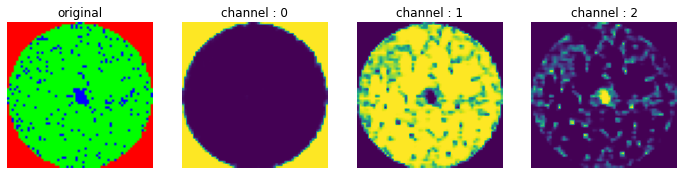

In [25]:
ae_model = cvae
ae_model.to('cpu')
fig, axes = plt.subplots(1, 4, figsize=(4*3, 1*3))
idx = np.random.randint(0, BATCH_SIZE)
X_b= X_train[:BATCH_SIZE]
recon_b = ae_model(X_b)[0]
idx=np.random.randint(0, BATCH_SIZE)
ax = axes[0]
ax.imshow(X_b[idx].permute(1,2,0))
ax.set_title("original")
ax.axis('off')

for i in range(3):
  ax = axes[i + 1]
  ax.imshow(recon_b.permute(0,2,3,1).detach().numpy()[idx,:,:,i])
  ax.set_title("channel : {}".format(i))
  ax.axis('off')

plt.show()
# 0(없음)이 보라색 1(있음)이 노란색
# 채널 0은 배경, 채널 1은 정상, 채널 2는 비정상 
# 0, 1, 2 - R, G, B

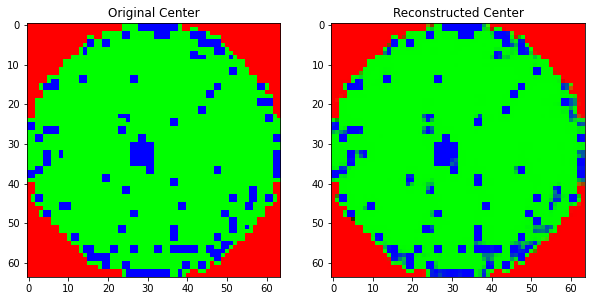

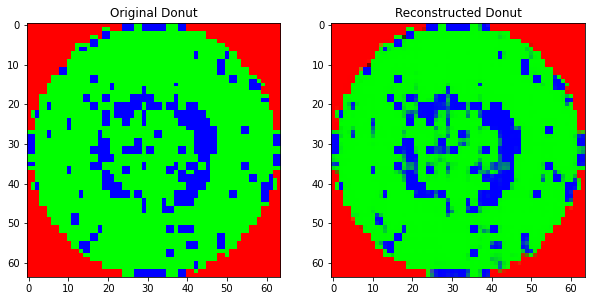

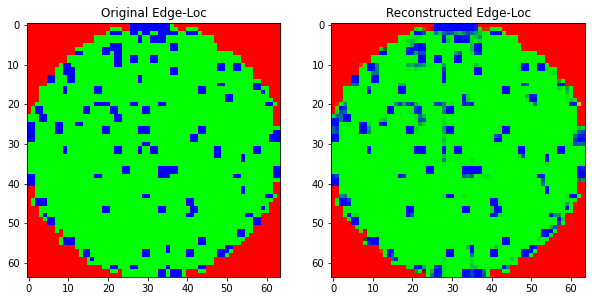

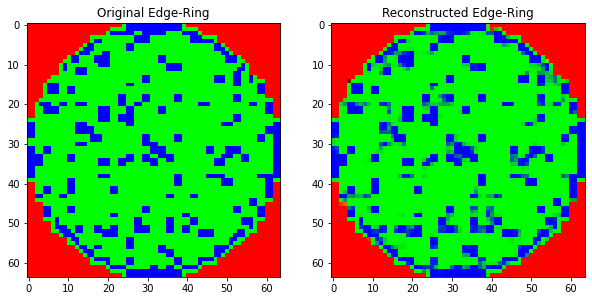

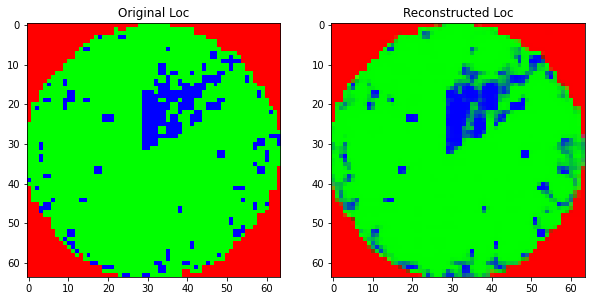

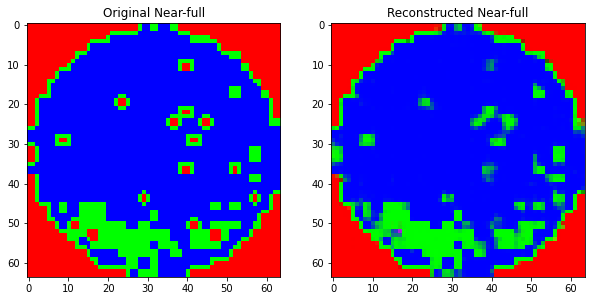

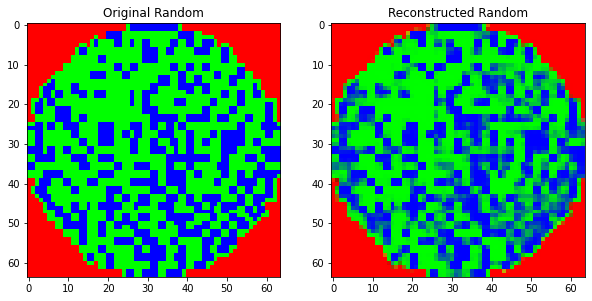

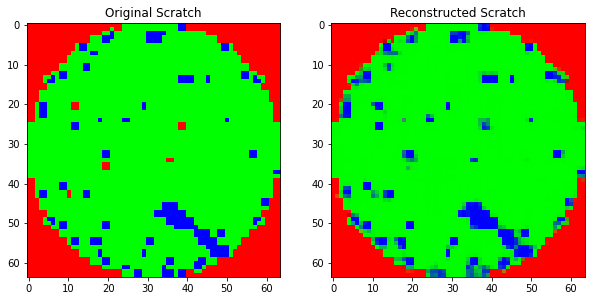

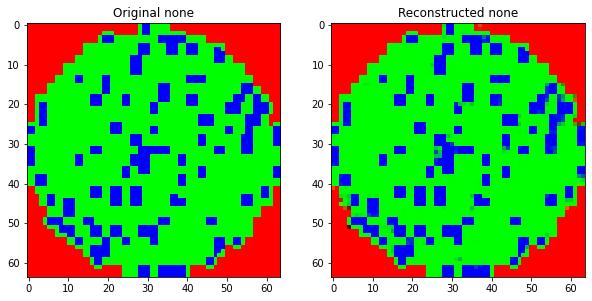

In [26]:
for f in faulty_case:
    lbl = np.unique(label)[f]
    tmp = np.where(y_train[:1000]==f)[0]
    idx = tmp[np.random.randint(0,len(tmp))] # 불량 케이스에 해당하는 인덱스
    x = X_train[idx]
    recon =  ae_model(X_train[:1000])[0][idx]

    fig = plt.figure(figsize=(10,20))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title("Original " + lbl)
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title("Reconstructed " + lbl)
    ax1.imshow(x.permute(1,2,0))
    ax2.imshow(recon.permute(1,2,0).detach().numpy())
    del tmp, x, recon
plt.show()

In [27]:
print(len(X_train))
for f in faulty_case :
    print('{} : {}'.format(f, len(y_train[y_train==f])))

24863
0 : 3006
1 : 389
2 : 3632
3 : 6776
4 : 2515
5 : 104
6 : 606
7 : 835
8 : 7000


In [29]:
# augment function
def gen_data(X, f): # X는 타겟 레이블을 가진 웨이퍼이미지 
    quot = 2400//len(X)
    iter = min(len(X)*quot, len(X))
    gen_x = torch.zeros(iter, 3, size, size) #dummy 
    for i in tqdm(range(iter)):
        recon_x = cvae(X[i].reshape(1, 3, size, size))
        gen_x[i] = recon_x[0].detach()
    gen_y = torch.full((len(gen_x),), f)
    assert len(gen_x) == len(gen_y)
    return gen_x, gen_y
    
# Augment
for f in faulty_case :
    for i in range(5):
        gc.collect()
        target_idx = np.where(y_train==f)[0]
        gen_x, gen_y = gen_data(X_train[target_idx], f)
        X_train = torch.cat((X_train, gen_x),dim=0)
        y_train = torch.cat((y_train, gen_y),dim=0)

print(len(X_train))
for f in faulty_case :
    print('{} : {}'.format(f, len(y_train[y_train==f])))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1556/1556 [00:27<00:00, 57.60it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1212/1212 [00:20<00:00, 59.43it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1670/1670 [00:28<00:00, 59.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


35133
0 : 3006
1 : 3112
2 : 3632
3 : 6776
4 : 2515
5 : 3328
6 : 2424
7 : 3340
8 : 7000


In [30]:
# Augmented dataset
train_dataset = WaferDataset(X_train, y_train, transform=transform)
val_dataset = WaferDataset(X_val, y_val, transform=None)
test_dataset = WaferDataset(X_test, y_test, transform=None)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
sample = next(iter(train_loader))
print(len(X_train), len(X_val), len(X_test))
print(sample[0].shape)

35133 5328 5328
torch.Size([64, 3, 64, 64])


In [33]:
# Transfer Learning
%cd C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\EfficientNet-PyTorch
from efficientnet_pytorch import EfficientNet 
effnet = EfficientNet.from_pretrained("efficientnet-b4", num_classes = 9) # Transfer learning
#summary(effnet, torch.zeros(BATCH_SIZE, 3, 64, 64))

C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\EfficientNet-PyTorch
Loaded pretrained weights for efficientnet-b4


In [48]:
%cd C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3
NUM_CLASSES = 9
class MyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_set1 = self.conv_layer_set(3, 16)
        self.conv_set2 = self.conv_layer_set(16, 32)
        self.conv_set3 = self.conv_layer_set(32, 64)
        self.conv_set4 = self.conv_layer_set(64, 128)
        self.maxpool = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc_set1 = self.fc_layer_set(8192, 256)
        self.fc_set2 = self.fc_layer_set(256, NUM_CLASSES)
        self.GAP = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_gap = self.fc_layer_set(128, NUM_CLASSES)
        
    def conv_layer_set(self, c_in, c_out, stride=1):
        # Conv-BN-Activation-Dropout-Pooling
        conv_set = nn.Sequential(
            nn.Conv2d(c_in, c_out, 3, stride, padding=1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        return conv_set

    def fc_layer_set(self, n_in, n_out):
        fc_set = nn.Sequential(
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        return fc_set

    def forward(self, x):
        x = self.conv_set1(x)
        x = self.maxpool(x)   # 32
        x = self.conv_set2(x)
        x = self.maxpool(x)   # 16
        x = self.conv_set3(x)
        x = self.maxpool(x)   # 8
        x = self.conv_set4(x)
        #x = self.GAP(x)
        x = self.flatten(x)
        #x = self.fc_gap(x)
        x = self.fc_set1(x)
        x = self.fc_set2(x)
        return x

mymodel = MyClassifier()
summary(mymodel, torch.zeros(BATCH_SIZE, 3, 64, 64))

C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3
                               Kernel Shape      Output Shape     Params  \
Layer                                                                      
0_conv_set1.Conv2d_0          [3, 16, 3, 3]  [64, 16, 64, 64]      448.0   
1_conv_set1.BatchNorm2d_1              [16]  [64, 16, 64, 64]       32.0   
2_conv_set1.ReLU_2                        -  [64, 16, 64, 64]          -   
3_conv_set1.Dropout_3                     -  [64, 16, 64, 64]          -   
4_maxpool                                 -  [64, 16, 32, 32]          -   
5_conv_set2.Conv2d_0         [16, 32, 3, 3]  [64, 32, 32, 32]      4.64k   
6_conv_set2.BatchNorm2d_1              [32]  [64, 32, 32, 32]       64.0   
7_conv_set2.ReLU_2                        -  [64, 32, 32, 32]          -   
8_conv_set2.Dropout_3                     -  [64, 32, 32, 32]          -   
9_maxpool                                 -  [64, 32, 16, 16]          -   
10_conv_set3.Conv2d_0      

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv_set1.Conv2d_0,"[3, 16, 3, 3]","[64, 16, 64, 64]",448.0,1769472.0
1_conv_set1.BatchNorm2d_1,[16],"[64, 16, 64, 64]",32.0,16.0
2_conv_set1.ReLU_2,-,"[64, 16, 64, 64]",NaN,NaN
3_conv_set1.Dropout_3,-,"[64, 16, 64, 64]",NaN,NaN
4_maxpool,-,"[64, 16, 32, 32]",NaN,NaN
5_conv_set2.Conv2d_0,"[16, 32, 3, 3]","[64, 32, 32, 32]",4640.0,4718592.0
6_conv_set2.BatchNorm2d_1,[32],"[64, 32, 32, 32]",64.0,32.0
7_conv_set2.ReLU_2,-,"[64, 32, 32, 32]",NaN,NaN
8_conv_set2.Dropout_3,-,"[64, 32, 32, 32]",NaN,NaN


Epoch 4:  68%|██████▊   | 430/633 [01:53<01:06,  3.04it/s, loss=3.66, v_num=5, train_loss_step=3.660, val_loss=1.750, val_acc=0.417, train_loss_epoch=0.997, train_acc=0.749]

In [51]:
# Lightning 
%cd C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3
class LitClassifier(LightningModule):
    def __init__(self, model, lr):
        super().__init__()
        self.model = model
        self.learning_rate = lr
        
    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx): # 한 batch에 대해서만 계산
        x, y = batch
        x = x.float()
        y = y.long()
        scores = self(x)
        pred = scores.argmax(dim=1)
        loss = F.cross_entropy(scores, y)
        #loss = F.nll_loss(scores, y)
        acc = accuracy(pred, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        x = x.float()
        y = y.long()
        scores = self(x)
        pred = scores.argmax(dim=1)     
        loss = F.cross_entropy(scores, y)
        #loss = F.nll_loss(scores, y)
        acc = accuracy(pred, y)
        if stage: # val or test
            self.log(f"{stage}_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            self.log(f"{stage}_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler_dict = {
            "scheduler": ReduceLROnPlateau(
                optimizer,
                mode='max',
                factor=0.5,
                patience=5, 
                threshold=0.05,
                threshold_mode='rel',
                cooldown=2, 
                verbose=True
            ),
            "interval" : "epoch",
            "monitor" : "val_acc"
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

# Callbacks
checkpoint = ModelCheckpoint(
    dirpath='./classifier',
    filename='model-{epoch:02d}-{val_acc:.4f}',
    save_top_k=1,
    monitor='val_acc',
    verbose=True,
    mode='max',
    save_weights_only=False,
    every_n_epochs = 1
)
earlystop = EarlyStopping(
    monitor='val_acc',
    min_delta=0.005,  # minimum value to determine 'improved'
    patience=10,
    verbose=True,
    mode='max'
) 
callbacks = [checkpoint, earlystop]

# Clf training
clfer = LitClassifier(effnet, lr=0.001)
trainer = Trainer(
    auto_lr_find=False,
    progress_bar_refresh_rate=10,
    min_epochs=10,
    max_epochs=50,
    gpus=1,
    logger=TensorBoardLogger("effnet_log", name='b4'), 
    callbacks=callbacks
)
trainer.tune(clfer, train_loader, val_loader)
trainer.fit(clfer, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 17.6 M
---------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params
70.259    Total estimated model params size (MB)


C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3
                                                              

Global seed set to 42


Epoch 0: 100%|██████████| 633/633 [02:19<00:00,  4.54it/s, loss=0.0169, v_num=0, train_loss_step=0.00457, val_loss=1.570, val_acc=0.565]

Metric val_acc improved. New best score: 0.565
Epoch 0, global step 548: val_acc reached 0.56513 (best 0.56513), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\classifier\model-epoch=00-val_acc=0.5651.ckpt" as top 1


Epoch 1: 100%|██████████| 633/633 [02:20<00:00,  4.52it/s, loss=0.0141, v_num=0, train_loss_step=0.00942, val_loss=1.950, val_acc=0.542, train_loss_epoch=0.319, train_acc=0.932]

Epoch 1, global step 1097: val_acc was not in top 1


Epoch 2: 100%|██████████| 633/633 [02:13<00:00,  4.74it/s, loss=0.0257, v_num=0, train_loss_step=0.0114, val_loss=2.940, val_acc=0.212, train_loss_epoch=0.315, train_acc=0.931]

Epoch 2, global step 1646: val_acc was not in top 1


Epoch 3: 100%|██████████| 633/633 [02:18<00:00,  4.57it/s, loss=0.00993, v_num=0, train_loss_step=0.00469, val_loss=1.830, val_acc=0.543, train_loss_epoch=0.303, train_acc=0.929]

Epoch 3, global step 2195: val_acc was not in top 1


Epoch 4: 100%|██████████| 633/633 [02:19<00:00,  4.55it/s, loss=0.0127, v_num=0, train_loss_step=0.00247, val_loss=1.610, val_acc=0.587, train_loss_epoch=0.344, train_acc=0.924]

Metric val_acc improved by 0.021 >= min_delta = 0.005. New best score: 0.587
Epoch 4, global step 2744: val_acc reached 0.58652 (best 0.58652), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\classifier\model-epoch=04-val_acc=0.5865.ckpt" as top 1


Epoch 5: 100%|██████████| 633/633 [02:21<00:00,  4.48it/s, loss=0.00603, v_num=0, train_loss_step=0.00477, val_loss=1.610, val_acc=0.564, train_loss_epoch=0.311, train_acc=0.924]

Epoch 5, global step 3293: val_acc was not in top 1


Epoch 6: 100%|██████████| 633/633 [02:19<00:00,  4.54it/s, loss=0.0339, v_num=0, train_loss_step=0.00896, val_loss=2.510, val_acc=0.215, train_loss_epoch=0.328, train_acc=0.928]

Epoch 6, global step 3842: val_acc was not in top 1


Epoch     7: reducing learning rate of group 0 to 5.0000e-04.
Epoch 7: 100%|██████████| 633/633 [02:18<00:00,  4.57it/s, loss=0.094, v_num=0, train_loss_step=0.0271, val_loss=2.080, val_acc=0.417, train_loss_epoch=0.349, train_acc=0.931]

Epoch 7, global step 4391: val_acc was not in top 1


Epoch 8: 100%|██████████| 633/633 [02:18<00:00,  4.56it/s, loss=0.169, v_num=0, train_loss_step=0.0551, val_loss=1.280, val_acc=0.662, train_loss_epoch=0.345, train_acc=0.911]

Metric val_acc improved by 0.075 >= min_delta = 0.005. New best score: 0.662
Epoch 8, global step 4940: val_acc reached 0.66179 (best 0.66179), saving model to "C:\Users\user\Drive\TNT\2021-2_TNT_Industrial_AI\TASK2\week3\classifier\model-epoch=08-val_acc=0.6618.ckpt" as top 1


Epoch 9: 100%|██████████| 633/633 [02:20<00:00,  4.52it/s, loss=0.258, v_num=0, train_loss_step=0.107, val_loss=1.650, val_acc=0.616, train_loss_epoch=0.327, train_acc=0.905]

Epoch 9, global step 5489: val_acc was not in top 1


Epoch 10: 100%|██████████| 633/633 [02:19<00:00,  4.56it/s, loss=0.392, v_num=0, train_loss_step=0.184, val_loss=1.850, val_acc=0.524, train_loss_epoch=0.366, train_acc=0.892]

Epoch 10, global step 6038: val_acc was not in top 1


Epoch 11: 100%|██████████| 633/633 [02:17<00:00,  4.60it/s, loss=0.386, v_num=0, train_loss_step=0.105, val_loss=2.500, val_acc=0.307, train_loss_epoch=0.393, train_acc=0.892]

Epoch 11, global step 6587: val_acc was not in top 1


Epoch 12: 100%|██████████| 633/633 [02:16<00:00,  4.64it/s, loss=0.158, v_num=0, train_loss_step=0.0726, val_loss=1.760, val_acc=0.575, train_loss_epoch=0.339, train_acc=0.905]

Epoch 12, global step 7136: val_acc was not in top 1


Epoch 13: 100%|██████████| 633/633 [02:11<00:00,  4.81it/s, loss=0.155, v_num=0, train_loss_step=0.0787, val_loss=2.530, val_acc=0.212, train_loss_epoch=0.349, train_acc=0.893]

Epoch 13, global step 7685: val_acc was not in top 1


Epoch 14: 100%|██████████| 633/633 [02:11<00:00,  4.81it/s, loss=0.362, v_num=0, train_loss_step=0.0547, val_loss=1.600, val_acc=0.624, train_loss_epoch=0.350, train_acc=0.893]

Epoch 14, global step 8234: val_acc was not in top 1


Epoch    15: reducing learning rate of group 0 to 2.5000e-04.
Epoch 15: 100%|██████████| 633/633 [02:12<00:00,  4.80it/s, loss=0.801, v_num=0, train_loss_step=0.561, val_loss=1.740, val_acc=0.601, train_loss_epoch=0.409, train_acc=0.875]

Epoch 15, global step 8783: val_acc was not in top 1


Epoch 16: 100%|██████████| 633/633 [02:13<00:00,  4.75it/s, loss=0.733, v_num=0, train_loss_step=0.550, val_loss=1.580, val_acc=0.595, train_loss_epoch=0.452, train_acc=0.852]

Epoch 16, global step 9332: val_acc was not in top 1


Epoch 17: 100%|██████████| 633/633 [02:11<00:00,  4.81it/s, loss=1.06, v_num=0, train_loss_step=0.817, val_loss=1.920, val_acc=0.551, train_loss_epoch=0.406, train_acc=0.840]

Epoch 17, global step 9881: val_acc was not in top 1


Epoch 18: 100%|██████████| 633/633 [02:12<00:00,  4.77it/s, loss=0.89, v_num=0, train_loss_step=0.608, val_loss=1.890, val_acc=0.471, train_loss_epoch=0.456, train_acc=0.808]

Monitored metric val_acc did not improve in the last 10 records. Best score: 0.662. Signaling Trainer to stop.
Epoch 18, global step 10430: val_acc was not in top 1


Epoch 18: 100%|██████████| 633/633 [02:12<00:00,  4.77it/s, loss=0.89, v_num=0, train_loss_step=0.608, val_loss=1.890, val_acc=0.471, train_loss_epoch=0.456, train_acc=0.808]


In [ ]:
x = X_train[:BATCH_SIZE]
y = y_train[:BATCH_SIZE]
pred = clfer(x).argmax(1)
print(accuracy(pred, y))
print(pred.eq(y).float().mean())
print(F.cross_entropy(clfer(x), y))
print(F.nll_loss(F.log_softmax(clfer(x), dim=1), y))

In [43]:
def train(model, loader, epoch):
    total_batches = len(loader)
    running_loss = 0.0 # Batch-wise
    running_acc = 0.0
    model.train()
    for batch_idx, (X, y) in enumerate(tqdm(loader)): # batch-wise
        X = X.to(device).float() # move to device, e.g. GPU
        y = y.to(device).long()
        # 순전파 
        scores = model(X)
        preds = scores.argmax(dim=1)
        loss = F.cross_entropy(scores, y)
        
        # 역전파 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        running_acc += preds.eq(y).float().mean()
        
    epoch_loss = running_loss / total_batches
    epoch_acc = running_acc / total_batches
    writer.add_scalar('train_loss', epoch_loss, epoch)
    writer.add_scalar('train_acc', epoch_acc, epoch)
    print('Epoch {} Train loss {:.4f}  Train accuracy {:.4f}'.format(epoch+1, epoch_loss, epoch_acc))
            
def validate(model, loader, epoch):
    running_loss = 0.0
    running_acc = 0.0
    total_batches = len(loader)
    model.eval() 
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(loader):
            X = X.to(device).float()
            y = y.to(device).long()
            scores = model(X)
            preds = scores.argmax(dim=1)
            loss = F.cross_entropy(scores, y)
            running_loss += loss.item()
            running_acc += preds.eq(y).float().mean()
    
        epoch_loss = running_loss / total_batches
        epoch_acc = running_acc / total_batches
        scheduler.step(epoch_loss) # val_loss가 개선되지 않으면 lr scheduler 실행
        writer.add_scalar('val_loss', epoch_loss, epoch)
        writer.add_scalar('val_acc', epoch_acc, epoch)
        print("EPOCH {} Val loss {:.4f}  Val accuracy {:.4f}".format(epoch+1, epoch_loss, epoch_acc))
        
def test(loader, model):
    running_acc = 0.0
    total_batches = len(loader)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for batch_dix, (X, y) in enumerate(loader):
            X = X.to(device).float()
            y = y.to(device).long()
            scores = model(X)
            pred = scores.argmax(dim=1)
            loss = F.cross_entropy(scores, y)
            running_loss += loss.item()
            running_acc += preds.eq(y).float().mean()

        epoch_loss = running_loss / total_batches
        epoch_acc = running_acc / total_batches
        print("test_accuracy : {:.4f}".format(epoch_acc))

torch.cuda.empty_cache() 
gc.collect()

Epoch 9:  55%|█████▌    | 350/633 [07:22<08:18,  1.76s/it, loss=2.2, v_num=2, train_loss_step=2.200, val_loss=2.200, val_acc=0.121, train_loss_epoch=2.200, train_acc=0.0856]


694

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# CUDA 메모리 정리 
model = effnet.to(device)
writer = SummaryWriter(log_dir='./effnet')

# hyperparameter
BATCH_SIZE = BATCH_SIZE
LEARNING_RATE = 0.003
NUM_EPOCHS = 30
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=5, 
                threshold=0.05,
                threshold_mode='rel',
                cooldown=1, 
                verbose=True
            )
            
for epoch in range(NUM_EPOCHS):
    train(model, train_loader, epoch)
    validate(model, val_loader, epoch)

In [66]:
gc.collect()


47

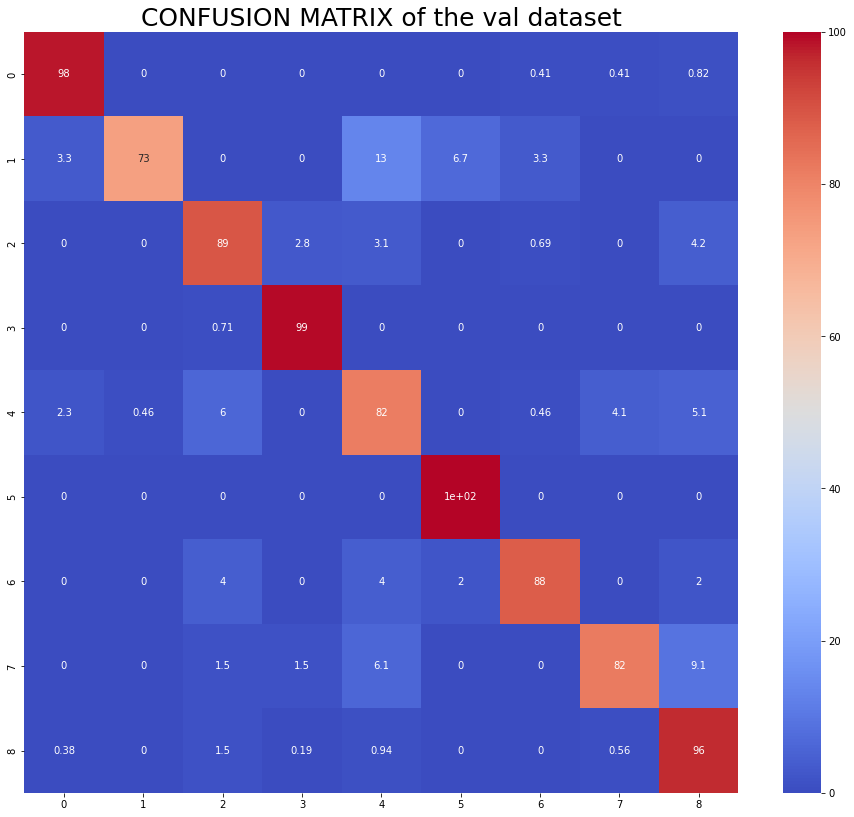

In [69]:
from sklearn.metrics import confusion_matrix
clfer.to('cpu')    
y_true = y_val[2000:4000]
y_pred = clfer(X_val[2000:4000]).argmax(axis=1)
plt.figure(figsize=(16,14))
sns.heatmap(
    confusion_matrix(y_true, y_pred, normalize = 'true')*100, 
    annot = True, 
    cmap='coolwarm')
del y_true 
del y_pred

plt.title("CONFUSION MATRIX of the val dataset", fontsize=25)
plt.show()

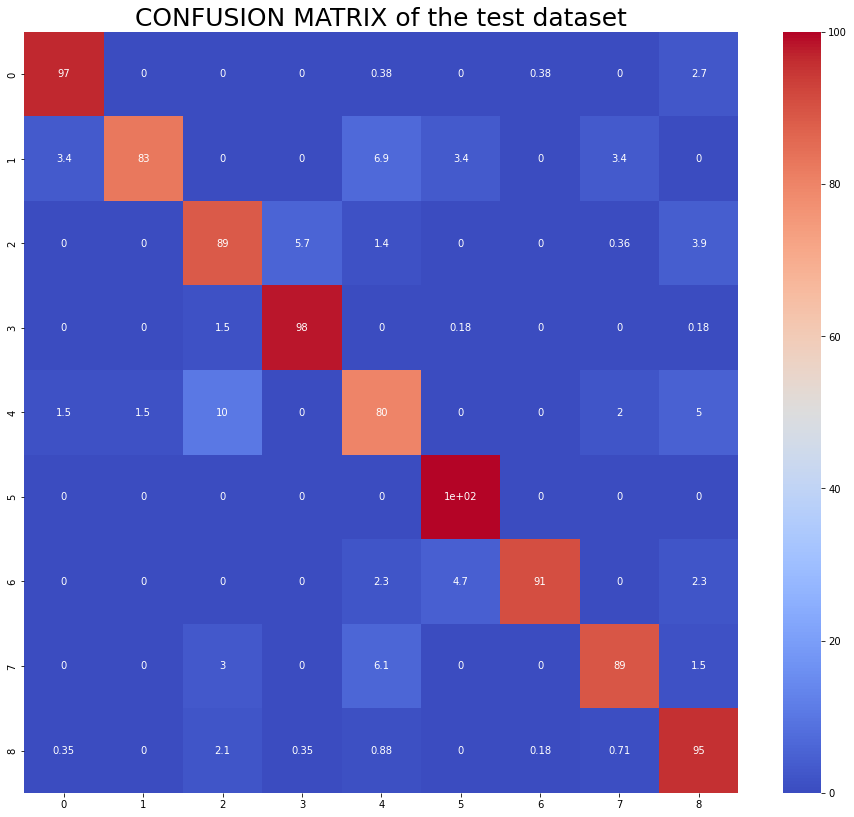

In [70]:
y_true = y_test[2000:4000]
y_pred = clfer(X_test[2000:4000]).argmax(axis=1)
plt.figure(figsize=(16,14))
sns.heatmap(
    confusion_matrix(y_true, y_pred, normalize = 'true')*100, 
    annot = True, 
    cmap='coolwarm')
    
del y_true 
del y_pred
plt.title("CONFUSION MATRIX of the test dataset", fontsize=25)
plt.show()